In [ ]:
from __future__ import annotations

from pathlib import Path
import pandas as pd
import numpy as np


# Constants (LOBSTER)
levels = 10
PRICE_SCALE = 10000.0
ASK_DUMMY = 9999999999
BID_DUMMY = -9999999999


def load_lobster(
    message_path: Path,
    orderbook_path: Path,
    levels: int = 10,
    price_scale: float = PRICE_SCALE,
    set_time_index: bool = True,
) -> pd.DataFrame:
    """
    Load LOBSTER message + orderbook files and return a single DataFrame.

    - Prices are kept in raw integer units (as in LOBSTER).
    - Dummy prices are replaced with NaN (only for price columns).
    - Adds top-of-book dollar columns (ask_p1_d, bid_p1_d), spread and mid (in dollars).
    """

    # Read message file
    msg_cols = ["time", "type", "order_id", "size", "price", "direction"]
    msg = pd.read_csv(
        message_path,
        header=None,
        names=msg_cols,
        dtype={
            "type": "int16",
            "order_id": "int64",
            "size": "int32",
            "price": "int64",
            "direction": "int8",
        },
    )
    msg["time"] = msg["time"].astype("float64")

    # Sanity check #1
    if not msg["time"].is_monotonic_increasing:
        raise ValueError("Message times are not monotonic increasing. Check input files.")

    # Read orderbook file
    ob_cols: list[str] = []
    for lvl in range(1, levels + 1):
        ob_cols += [f"ask_p{lvl}", f"ask_s{lvl}", f"bid_p{lvl}", f"bid_s{lvl}"]

    ob = pd.read_csv(
        orderbook_path,
        header=None,
        names=ob_cols,
        usecols=list(range(4 * levels)),
    )

    # Set dtypes explicitly (prices int64, sizes int32)
    for c in ob_cols:
        ob[c] = ob[c].astype("int64" if "_p" in c else "int32")

    # Sanity check #2: message rows must match orderbook rows
    if len(msg) != len(ob):
        raise ValueError(f"Row mismatch: msg={len(msg)} vs ob={len(ob)}")

    #  Combine
    df = pd.concat([msg.reset_index(drop=True), ob.reset_index(drop=True)], axis=1)

    # Keep time as a column; optionally also use it as index (index can have duplicates)
    df = df.sort_values("time", kind="mergesort")  # stable sort
    if set_time_index:
        df = df.set_index("time", drop=False)

    # Dummy handling (price columns only)
    ask_price_cols = [f"ask_p{i}" for i in range(1, levels + 1)]
    bid_price_cols = [f"bid_p{i}" for i in range(1, levels + 1)]

    dummy_before = (
        (df[ask_price_cols] == ASK_DUMMY).sum().sum()
        + (df[bid_price_cols] == BID_DUMMY).sum().sum()
    )

    for col in ask_price_cols:
        df.loc[df[col] == ASK_DUMMY, col] = np.nan
    for col in bid_price_cols:
        df.loc[df[col] == BID_DUMMY, col] = np.nan

    dummy_after = (
        (df[ask_price_cols] == ASK_DUMMY).sum().sum()
        + (df[bid_price_cols] == BID_DUMMY).sum().sum()
    )

    if dummy_after != 0:
        raise ValueError("Dummy replacement failed: some dummy prices are still present.")

    # Top-of-book derived fields (dollars)
    df["ask_p1_d"] = df["ask_p1"] / price_scale
    df["bid_p1_d"] = df["bid_p1"] / price_scale

    # spread & mid only where both sides exist
    valid_top = df["ask_p1"].notna() & df["bid_p1"].notna()
    df["spread"] = np.nan
    df["mid"] = np.nan
    df.loc[valid_top, "spread"] = (df.loc[valid_top, "ask_p1"] - df.loc[valid_top, "bid_p1"]) / price_scale
    df.loc[valid_top, "mid"] = (df.loc[valid_top, "ask_p1"] + df.loc[valid_top, "bid_p1"]) / (2 * price_scale)

    # Sanity check #3: spread should be >= 0 almost always (allow tiny tolerance)
    neg_share = (df.loc[valid_top, "spread"] < 0).mean()
    if neg_share > 1e-6:
        nneg = int((df.loc[valid_top, "spread"] < 0).sum())
        raise ValueError(f"Negative spread found in {nneg} rows ({neg_share:.2e} share).")

    # Lightweight info (helps debugging, not too verbose)
    print(f"Loaded: {message_path.name}")
    print(f"Rows: {len(df):,} | Dummy prices replaced: {int(dummy_before):,} | Negative-spread share: {neg_share:.2e}")

    return df


def save_processed(df: pd.DataFrame, out_path: Path) -> None:
    """
    Save processed dataset. Tries Parquet first; falls back to pickle if Parquet engine is missing.
    """
    out_path.parent.mkdir(parents=True, exist_ok=True)

    try:
        df.to_parquet(out_path, index=True)
        print(f"Saved parquet -> {out_path}")
    except Exception as e:
        fallback = out_path.with_suffix(".pkl")
        df.to_pickle(fallback)
        print(f"Parquet failed ({type(e).__name__}). Saved pickle -> {fallback}")


# Usage (adjust paths to your repo layout)
DATA_DIR = Path("..") / "Data"         # or: Path("..") / "data" / "raw"
PROCESSED_DIR = Path("..") / "data" / "processed"

message_path = next(DATA_DIR.glob("*_message_10.csv"))
orderbook_path = next(DATA_DIR.glob("*_orderbook_10.csv"))

df = load_lobster(message_path, orderbook_path, levels=10, set_time_index=True)

df.head()


Loaded: GOOG_2012-06-21_34200000_57600000_message_10.csv
Rows: 147,916 | Dummy prices replaced: 0 | Negative-spread share: 0.00e+00
Parquet failed (ValueError). Saved pickle -> ../data/processed/goog_2012-06-21.pkl


,time,type,order_id,size,price,direction,ask_p1,ask_s1,bid_p1,bid_s1,...,bid_p9,bid_s9,ask_p10,ask_s10,bid_p10,bid_s10,ask_p1_d,bid_p1_d,spread,mid
time,,,,,,,,,,,,,,,,,,,,,
34200.015105,34200.015105,4,15818974,4,5794000,1,5802300.0,100,5794000.0,496,...,5732000.0,20,5892600.0,100,5700000.0,100,580.23,579.4,0.83,579.815
34200.059902,34200.059902,4,15818974,300,5794000,1,5802300.0,100,5794000.0,196,...,5732000.0,20,5892600.0,100,5700000.0,100,580.23,579.4,0.83,579.815
34200.113247,34200.113247,5,0,1,5795100,1,5802300.0,100,5794000.0,196,...,5732000.0,20,5892600.0,100,5700000.0,100,580.23,579.4,0.83,579.815
34200.113247,34200.113247,5,0,1,5795000,1,5802300.0,100,5794000.0,196,...,5732000.0,20,5892600.0,100,5700000.0,100,580.23,579.4,0.83,579.815
34200.113247,34200.113247,5,0,1,5794900,1,5802300.0,100,5794000.0,196,...,5732000.0,20,5892600.0,100,5700000.0,100,580.23,579.4,0.83,579.815


In [ ]:
# --- Persist (optional) ---
# Uncomment to save a processed dataset for faster downstream notebooks
# save_processed(df, PROCESSED_DIR / "goog_2012-06-21.parquet")

In [ ]:
# Quick integrity checks
print("Shape:", df.shape)
print("Time range:", df["time"].min(), "->", df["time"].max())

# Top-of-book availability
valid_top = df["ask_p1"].notna() & df["bid_p1"].notna()
print("Top-of-book available:", f"{valid_top.mean():.4%}")

# Spread sanity
print("Spread < 0 count:", int((df.loc[valid_top, "spread"] < 0).sum()))
print("Spread == 0 count:", int((df.loc[valid_top, "spread"] == 0).sum()))

df[["ask_p1_d", "bid_p1_d", "spread", "mid"]].describe()


Shape: (147916, 50)
Time range: 34200.015105074 -> 57599.871751084
Top-of-book available: 100.0000%
Spread < 0 count: 0
Spread == 0 count: 0


,ask_p1_d,bid_p1_d,spread,mid
count,147916.000000,147916.000000,147916.000000,147916.000000
mean,570.931347,570.635106,0.296241,570.783227
std,4.039192,3.972411,0.148140,4.005256
min,563.750000,563.710000,0.010000,563.730000
25%,567.970000,567.700000,0.200000,567.825000
50%,570.010000,569.750000,0.280000,569.880000
75%,575.420000,575.100000,0.360000,575.255000
max,580.230000,579.400000,2.310000,579.815000


In [ ]:
# Missing levels due to dummy
ask_price_cols = [f"ask_p{i}" for i in range(1, levels + 1)]
bid_price_cols = [f"bid_p{i}" for i in range(1, levels + 1)]

print("NaN share (ask prices) by level:")
print((df[ask_price_cols].isna().mean()).to_string())

print("\nNaN share (bid prices) by level:")
print((df[bid_price_cols].isna().mean()).to_string())


NaN share (ask prices) by level:
ask_p1     0.0
ask_p2     0.0
ask_p3     0.0
ask_p4     0.0
ask_p5     0.0
ask_p6     0.0
ask_p7     0.0
ask_p8     0.0
ask_p9     0.0
ask_p10    0.0

NaN share (bid prices) by level:
bid_p1     0.0
bid_p2     0.0
bid_p3     0.0
bid_p4     0.0
bid_p5     0.0
bid_p6     0.0
bid_p7     0.0
bid_p8     0.0
bid_p9     0.0
bid_p10    0.0


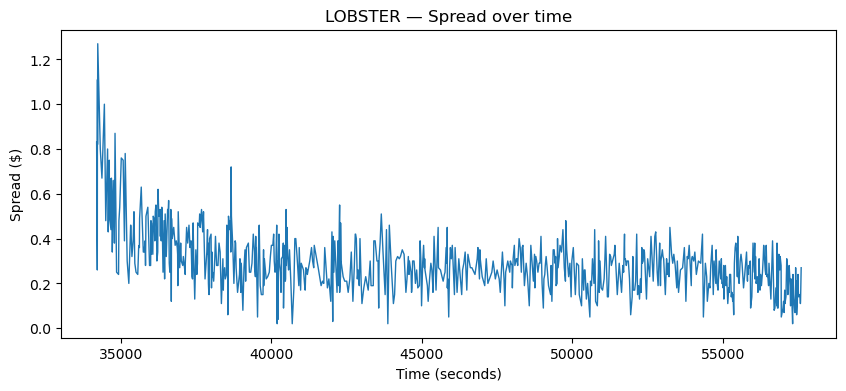

In [11]:
import matplotlib.pyplot as plt

# Spread over time
sample = df.loc[df["spread"].notna(), ["time", "spread"]].iloc[::200]
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(sample["time"], sample["spread"], linewidth=1)
ax.set_title("LOBSTER — Spread over time")
ax.set_xlabel("Time (seconds)")
ax.set_ylabel("Spread ($)")
plt.show()
